Lambda School Data Science

*Unit 4, Sprint 1, Module 3*

---

# Document Classification (Assignment)

This notebook is for you to practice skills during lecture.

Today's guided module project and assignment will be different. You already know how to do classification. You ready know how to extract features from documents. So? That means you're ready to combine and practice those skills in a kaggle competition. We we will open with a five minute sprint explaining the competition, and then give you 25 minutes to work. After those twenty five minutes are up, I will give a 5-minute demo an NLP technique that will help you with document classification (*and **maybe** the competition*).

Today's all about having fun and practicing your skills.

## Sections
* <a href="#p1">Part 1</a>: Text Feature Extraction & Classification Pipelines
* <a href="#p2">Part 2</a>: Latent Semantic Indexing
* <a href="#p3">Part 3</a>: Word Embeddings with Spacy
* <a href="#p4">Part 4</a>: Post Lecture Assignment

# Text Feature Extraction & Classification Pipelines (Learn)
<a id="p1"></a>

## Follow Along 

What you should be doing now:
1. Join the Kaggle Competition
2. Download the data
3. Train a model (try using the pipe method I just demoed)

### Load Competition Data

In [1]:
# Imports
import re
import pandas as pd

# Avoid warnings
import warnings
warnings.filterwarnings("ignore")

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import TruncatedSVD
import scipy.stats as stats
import spacy
from spacy.tokenizer import Tokenizer

# ML helper functions
from explore_data import get_num_words_per_sample 
from explore_data import plot_sample_length_distribution
from explore_data import plot_class_distribution
from explore_data import plot_frequency_distribution_of_ngrams

# Visualizations
import eli5
import seaborn as sns
sns.set()

# Set option to view max column width
pd.set_option('display.max_colwidth', None)

In [2]:
# Load spaCy medium model
nlp = spacy.load('en_core_web_md')

In [3]:
# Show a progress bar
from tqdm import tqdm
tqdm.pandas()

In [4]:
# You may need to change the path
train = pd.read_csv('./whiskey-reviews-dspt8/train.csv')
test = pd.read_csv('./whiskey-reviews-dspt8/test.csv')

# What is the sizes
print(f' Train Set: {train.shape}\n', f'Test Set: {test.shape}')

 Train Set: (4087, 3)
 Test Set: (1022, 2)


In [5]:
# Look at the first 5 rows
train.head()

,id,description,ratingCategory
0,1321,"\nSometimes, when whisky is batched, a few leftover barrels are returned to the warehouse. Canadian Club recently pulled and vatted several of these from the 1970s. Acetone, Granny Smith apples, and fresh-cut white cedar showcase this long age. Complex and spicy, yet reserved, this dram is ripe with strawberries, canned pears, cloves, pepper, and faint flowers, then slightly pulling oak tannins. Distinct, elegant, and remarkably vibrant, this ancient Canadian Club is anything but tired. (Australia only) A$133",1
1,3861,"\nAn uncommon exclusive bottling of a 6 year old cask strength malt. Light gold in color, the nose is vegetal, more peat bog than peat smoke, with an undercurrent of pastry cream and rose. It’s an odd combination of aromas. The entry is flavorful and inviting with smoked pineapple, clove, and rose. Peak smoke arrives in full force in the mid-palate, which drops the sweet and becomes spicy. The finish is mostly smoke, but with a pleasant minty coolness. (Wyoming only)",0
2,655,"\nThis release is a port version of Amrut’s Intermediate Sherry — a sort of port pipe sandwich. The spirit is matured in both unused casks and bourbon casks, then spends a few months in port pipes, and then returns to bourbon casks. The result is a Pink Floyd show of a whisky: vibrant, colorful, complex, and nearly too much. A blackcurrant and wispy, smoky nose gives way to an intense and bittersweet mix of chili, blackcurrant, oak, damson, dark chocolate, and peat. Astounding.",1
3,555,"\nThis 41 year old single cask was aged in a sherry butt and interacted magnificently with that wood. The nose offers peeled red apples, sultanas, honey, fudge, milk chocolate, and American cream soda. Balanced and harmonious throughout, the palate yields remarkably fresh orchard fruits, pipe tobacco, black pepper, and ginger. Long in the finish, with cinnamon drying to dark chocolate, and slightly smoky, unobtrusively tannic oak. A 1970s classic!",1
4,1965,"\nQuite herbal on the nose, with aromas of dried tarragon, parsley, and dill, along with cherry, milk chocolate, orange blossom, vanilla bean, and sweet tea. The palate is slightly grain-forward, but is full and well balanced, with orange, dried flowers, chamomile tea, lemon rind, and ginger. The finish offers cinnamon and milk chocolate against a note of candied lemon. Youthful and barrel-influenced, but admirably executed.",1


In [6]:
# Show the distribution of the rating category in percentages
# 0 = Excellent
# 1 = Good
# 2 = Poor
train.ratingCategory.value_counts(normalize=True)

1    0.704918
0    0.279178
2    0.015904
Name: ratingCategory, dtype: float64

In [7]:
# Look at some of the reviews in the "Excellent" category
train[train.ratingCategory == 0].sample(3)

,id,description,ratingCategory
2111,3876,"\nA nose of white pepper and spice, as well as salty brine, light sea smoke, and toasted wood, followed by white chocolate, confectionery sweetness, and wild berries. Rich and full on a front palate that’s somewhat youthful, led by notes of vanilla, milk chocolate, marzipan, and treacle, with lemon and almond adding some zest. The finish lingers, with a hint of salinity and toasted wood, as well as light smoke.",0
1099,4132,"\nSpicy and botanical on the nose, with notes of ginger, juniper, lemon grass, orange, and grapefruit rind. Similar follow-through on the palate, with added notes of vanilla, honeyed malt, and hay. Gentle, dried herb and spice finish. Certainly some interesting -- perhaps even peculiar -- flavors from this product of the demolished Lowland distillery.",0
1664,4251,"\nFrom a bourbon-style mashbill matured in new Missouri oak, this first whisky from 66 Gilead salutes Wild Oak farm, where contented cattle dine on the distillery’s spent grains. Dry grain, gray weathered wood, sea breezes, caramel, and soft, earthy, woody notes become vanilla, saltwater taffy, cherries, and fruit punch, with herbal hints of celery. It’s hot and spicy with sizzling pepper and searing ginger over a barrelhouse woodiness. Young, but not rough, with a long, peppery finish.",0


In [8]:
# Look at some of the reviews in the "Poor" category
train[train.ratingCategory == 2].sample(3)

,id,description,ratingCategory
1163,5085,"\nA quadruple-distilled whisky in a glass-stoppered bottle, the sherry influence has left its mark on the nose with ripe Victoria plums, glacé cherry, ripening strawberries, icing sugar, and mixed peel. Too bad the flavors are profoundly bitter and minty, producing an expression on this reviewer’s face like a flinching child reluctantly ingesting an unwelcome spoonful of medicine. More palatable and fruity as it dilutes, some spearmint returns on the finish, but it was game over by then.",2
86,5044,"\nAn oddball whiskey by all accounts, with a very high 72.2% of wheat in the mashbill, distillation on an old farmhouse cognac still, and aging in a little Oregon barn in 63-gallon new oak barrels. The result is a strange, disjointed whiskey that starts out pillow-soft with wheat and caramel, and then dramatically shifts to raw oak, nougat, and cinnamon stick. The flavors in Billy don’t integrate well: they're like a jazz band severely out of step.",2
2032,5098,"\nI love Rogue beers, as well as Rogue’s attitude and philosophy. But this whiskey just tastes too immature—harsh, sweet, and one-dimensional. Maybe with some additional aging it might come around, mellow out, and develop, but it has a long way to go.",2


In [9]:
# Look at the orginal median words per sample
median_words = get_num_words_per_sample(train.description)
print(f'Median Words / Sample: {median_words}')

Median Words / Sample: 70.0


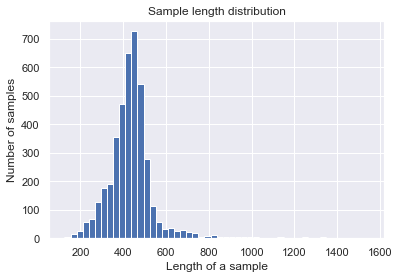

In [10]:
# Plot the length of characters per sample
plot_sample_length_distribution(train.description)

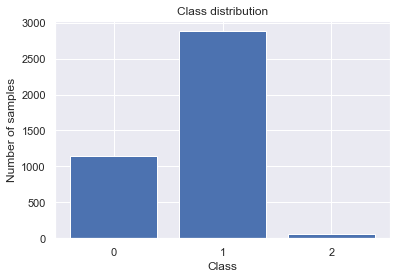

In [11]:
# Plot the class distribution of the target feature
plot_class_distribution(train.ratingCategory)

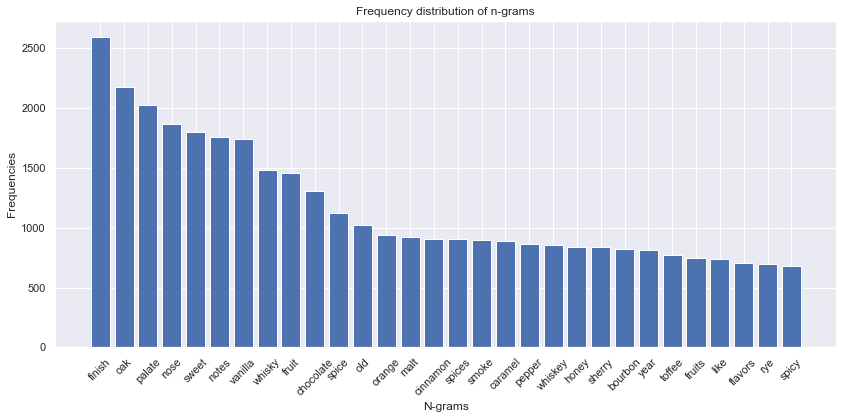

In [12]:
# Plot the count of the top 30 ngrams
plot_frequency_distribution_of_ngrams(train.description,
                                     ngram_range=(1, 2),
                                     num_ngrams=30)

### Do some cleaning on text and tokenize before splitting

In [13]:
# Clean data before tokenizing
def clean_text(df):
    data = []
    
    for i in range(len(df)):
        x = re.sub(r'^\\n$', '', df[i])  # Remove new line chars
        x1 = x.lower()  # Lowercase words
        x2 = re.sub('[^a-z A-Z 0-9]', ' ', x1)  # Remove anything not alpha numeric
        data.append(x2) # Add cleaned data to the end of the data list
    
    return data

In [14]:
# Use my function to clean the text in the train set
train['cleaned'] = clean_text(train.description)

# Check my work
train.head()

,id,description,ratingCategory,cleaned
0,1321,"\nSometimes, when whisky is batched, a few leftover barrels are returned to the warehouse. Canadian Club recently pulled and vatted several of these from the 1970s. Acetone, Granny Smith apples, and fresh-cut white cedar showcase this long age. Complex and spicy, yet reserved, this dram is ripe with strawberries, canned pears, cloves, pepper, and faint flowers, then slightly pulling oak tannins. Distinct, elegant, and remarkably vibrant, this ancient Canadian Club is anything but tired. (Australia only) A$133",1,sometimes when whisky is batched a few leftover barrels are returned to the warehouse canadian club recently pulled and vatted several of these from the 1970s acetone granny smith apples and fresh cut white cedar showcase this long age complex and spicy yet reserved this dram is ripe with strawberries canned pears cloves pepper and faint flowers then slightly pulling oak tannins distinct elegant and remarkably vibrant this ancient canadian club is anything but tired australia only a 133
1,3861,"\nAn uncommon exclusive bottling of a 6 year old cask strength malt. Light gold in color, the nose is vegetal, more peat bog than peat smoke, with an undercurrent of pastry cream and rose. It’s an odd combination of aromas. The entry is flavorful and inviting with smoked pineapple, clove, and rose. Peak smoke arrives in full force in the mid-palate, which drops the sweet and becomes spicy. The finish is mostly smoke, but with a pleasant minty coolness. (Wyoming only)",0,an uncommon exclusive bottling of a 6 year old cask strength malt light gold in color the nose is vegetal more peat bog than peat smoke with an undercurrent of pastry cream and rose it s an odd combination of aromas the entry is flavorful and inviting with smoked pineapple clove and rose peak smoke arrives in full force in the mid palate which drops the sweet and becomes spicy the finish is mostly smoke but with a pleasant minty coolness wyoming only
2,655,"\nThis release is a port version of Amrut’s Intermediate Sherry — a sort of port pipe sandwich. The spirit is matured in both unused casks and bourbon casks, then spends a few months in port pipes, and then returns to bourbon casks. The result is a Pink Floyd show of a whisky: vibrant, colorful, complex, and nearly too much. A blackcurrant and wispy, smoky nose gives way to an intense and bittersweet mix of chili, blackcurrant, oak, damson, dark chocolate, and peat. Astounding.",1,this release is a port version of amrut s intermediate sherry a sort of port pipe sandwich the spirit is matured in both unused casks and bourbon casks then spends a few months in port pipes and then returns to bourbon casks the result is a pink floyd show of a whisky vibrant colorful complex and nearly too much a blackcurrant and wispy smoky nose gives way to an intense and bittersweet mix of chili blackcurrant oak damson dark chocolate and peat astounding
3,555,"\nThis 41 year old single cask was aged in a sherry butt and interacted magnificently with that wood. The nose offers peeled red apples, sultanas, honey, fudge, milk chocolate, and American cream soda. Balanced and harmonious throughout, the palate yields remarkably fresh orchard fruits, pipe tobacco, black pepper, and ginger. Long in the finish, with cinnamon drying to dark chocolate, and slightly smoky, unobtrusively tannic oak. A 1970s classic!",1,this 41 year old single cask was aged in a sherry butt and interacted magnificently with that wood the nose offers peeled red apples sultanas honey fudge milk chocolate and american cream soda balanced and harmonious throughout the palate yields remarkably fresh orchard fruits pipe tobacco black pepper and ginger long in the finish with cinnamon drying to dark chocolate and slightly smoky unobtrusively tannic oak a 1970s classic
4,1965,"\nQuite herbal on the nose, with aromas of dried tarragon, parsley, and dill, along with cherry, milk chocolate, orange blossom, vanilla bean, and 

In [15]:
# Use my function to clean the text in the test set
test['cleaned'] = clean_text(test.description)

# Check my work
test.head()

,id,description,cleaned
0,3461,"\nStyle: Speyside single malt scotch Color: Walnut Aroma: Richly sherried and thick, with notes of nuts and toffee. Wood resins contribute spice and variety. Fruitcake at Christmas. Palate: Thick, chewy in texture, and quite ripe. Again the fruitcake. Very deep and mature with some underlying maltiness. Dry, spicy, oak notes fight off all that sherry and add balance and complexity. Long, soothing finish. \r\n",style speyside single malt scotch color walnut aroma richly sherried and thick with notes of nuts and toffee wood resins contribute spice and variety fruitcake at christmas palate thick chewy in texture and quite ripe again the fruitcake very deep and mature with some underlying maltiness dry spicy oak notes fight off all that sherry and add balance and complexity long soothing finish
1,2604,"\nVery bright and lively, with a nice balance of flavors. Zesty fruit (lemon, peach, ripe pineapple, golden raisin) on a bed of layered sweetness (creamy vanilla, light honey, lightly toasted marshmallow, and a hint of coconut). Gently dry, delicately spicy, dried citrus finish. Light enough and with enough zing to enjoy before dinner, but it should stand up well enough after dinner, too. This is a nice whisky, but it shows a lighter, more elegant side of Glenrothes. It doesn’t express the rich, opulent notes often shown in bottlings like the 1972 Vintage, for example.",very bright and lively with a nice balance of flavors zesty fruit lemon peach ripe pineapple golden raisin on a bed of layered sweetness creamy vanilla light honey lightly toasted marshmallow and a hint of coconut gently dry delicately spicy dried citrus finish light enough and with enough zing to enjoy before dinner but it should stand up well enough after dinner too this is a nice whisky but it shows a lighter more elegant side of glenrothes it doesn t express the rich opulent notes often shown in bottlings like the 1972 vintage for example
2,3341,"\nA new oloroso-forward Chivas positioned to split between the 12 and 18 year olds? I got this. Refined and inviting nose of lemon pith, black fruits, and Kola Kubes. The velvety texture is wonderfully smooth, redolent of an apricot custard Danish, lime zest, raisin, currant, mixed peel, and walnut, with a growing bitter-lemon note. Quite unique finish, like sucking on lumpy Spanish lemons speckled with spices. (LA, NY, Miami, Chicago, Northern California, but will go national)",a new oloroso forward chivas positioned to split between the 12 and 18 year olds i got this refined and inviting nose of lemon pith black fruits and kola kubes the velvety texture is wonderfully smooth redolent of an apricot custard danish lime zest raisin currant mixed peel and walnut with a growing bitter lemon note quite unique finish like sucking on lumpy spanish lemons speckled with spices la ny miami chicago northern california but will go national
3,3764,"\nAged in bourbon casks and then enhanced in Rioja wine casks. A mélange of red berry fruits, firm malt, thick vanilla and spicy oak, along with a hint of grape skin, anise, and orange peel. Gritty, dry finish.",aged in bourbon casks and then enhanced in rioja wine casks a m lange of red berry fruits firm malt thick vanilla and spicy oak along with a hint of grape skin anise and orange peel gritty dry finish
4,2306,"\nThere is a freshness to the wood on the nose, laced with caramel and delicate minty notes. The palate pours pleasantly chewy with molten butterscotch and offers a pleasant jolt of cinnamon and clove that suggests rye at work, before settling on bitter orange peel, salted caramel, and cocoa, leading to a drying leathery and warm spice finish. Nicely done.",there is a freshness to the wood on the nose laced with caramel and delicate minty notes the palate pours pleasantly chewy with molten butterscotch and offers a pleasant jolt of cinnamon and clove that suggests rye at work before settling on bitter orange peel salted caramel and cocoa leading

In [16]:
# Create a new df with just the id and cleaned columns
clean_train = train[['id', 'cleaned', 'ratingCategory']]

# Check my work
clean_train.head()

,id,cleaned,ratingCategory
0,1321,sometimes when whisky is batched a few leftover barrels are returned to the warehouse canadian club recently pulled and vatted several of these from the 1970s acetone granny smith apples and fresh cut white cedar showcase this long age complex and spicy yet reserved this dram is ripe with strawberries canned pears cloves pepper and faint flowers then slightly pulling oak tannins distinct elegant and remarkably vibrant this ancient canadian club is anything but tired australia only a 133,1
1,3861,an uncommon exclusive bottling of a 6 year old cask strength malt light gold in color the nose is vegetal more peat bog than peat smoke with an undercurrent of pastry cream and rose it s an odd combination of aromas the entry is flavorful and inviting with smoked pineapple clove and rose peak smoke arrives in full force in the mid palate which drops the sweet and becomes spicy the finish is mostly smoke but with a pleasant minty coolness wyoming only,0
2,655,this release is a port version of amrut s intermediate sherry a sort of port pipe sandwich the spirit is matured in both unused casks and bourbon casks then spends a few months in port pipes and then returns to bourbon casks the result is a pink floyd show of a whisky vibrant colorful complex and nearly too much a blackcurrant and wispy smoky nose gives way to an intense and bittersweet mix of chili blackcurrant oak damson dark chocolate and peat astounding,1
3,555,this 41 year old single cask was aged in a sherry butt and interacted magnificently with that wood the nose offers peeled red apples sultanas honey fudge milk chocolate and american cream soda balanced and harmonious throughout the palate yields remarkably fresh orchard fruits pipe tobacco black pepper and ginger long in the finish with cinnamon drying to dark chocolate and slightly smoky unobtrusively tannic oak a 1970s classic,1
4,1965,quite herbal on the nose with aromas of dried tarragon parsley and dill along with cherry milk chocolate orange blossom vanilla bean and sweet tea the palate is slightly grain forward but is full and well balanced with orange dried flowers chamomile tea lemon rind and ginger the finish offers cinnamon and milk chocolate against a note of candied lemon youthful and barrel influenced but admirably executed,1


In [17]:
# Create a new df with just the id and cleaned columns
clean_test = test[['id', 'cleaned']]

# Check my work
clean_test.head()

,id,cleaned
0,3461,style speyside single malt scotch color walnut aroma richly sherried and thick with notes of nuts and toffee wood resins contribute spice and variety fruitcake at christmas palate thick chewy in texture and quite ripe again the fruitcake very deep and mature with some underlying maltiness dry spicy oak notes fight off all that sherry and add balance and complexity long soothing finish
1,2604,very bright and lively with a nice balance of flavors zesty fruit lemon peach ripe pineapple golden raisin on a bed of layered sweetness creamy vanilla light honey lightly toasted marshmallow and a hint of coconut gently dry delicately spicy dried citrus finish light enough and with enough zing to enjoy before dinner but it should stand up well enough after dinner too this is a nice whisky but it shows a lighter more elegant side of glenrothes it doesn t express the rich opulent notes often shown in bottlings like the 1972 vintage for example
2,3341,a new oloroso forward chivas positioned to split between the 12 and 18 year olds i got this refined and inviting nose of lemon pith black fruits and kola kubes the velvety texture is wonderfully smooth redolent of an apricot custard danish lime zest raisin currant mixed peel and walnut with a growing bitter lemon note quite unique finish like sucking on lumpy spanish lemons speckled with spices la ny miami chicago northern california but will go national
3,3764,aged in bourbon casks and then enhanced in rioja wine casks a m lange of red berry fruits firm malt thick vanilla and spicy oak along with a hint of grape skin anise and orange peel gritty dry finish
4,2306,there is a freshness to the wood on the nose laced with caramel and delicate minty notes the palate pours pleasantly chewy with molten butterscotch and offers a pleasant jolt of cinnamon and clove that suggests rye at work before settling on bitter orange peel salted caramel and cocoa leading to a drying leathery and warm spice finish nicely done


### Train / Validate split

In [18]:
# Import train/test split function
from sklearn.model_selection import train_test_split

# Use train/test split to get a validation set to test on
X_train, X_val, y_train, y_val = train_test_split(clean_train.cleaned,
                                                   clean_train['ratingCategory'],
                                                   test_size=0.2,
                                                   stratify=clean_train['ratingCategory'],
                                                   random_state=97)

# Look at the sizes
print(f' X_train: {X_train.shape}\n', f'X_test: {X_val.shape}\n', 
      f'y_train: {y_train.shape}\n', f'y_test: {y_val.shape}')

 X_train: (3269,)
 X_test: (818,)
 y_train: (3269,)
 y_test: (818,)


In [19]:
# Get the median words per sample on the new training set
median_words_train = get_num_words_per_sample(X_train)
print(f'Median Words/Sample: {median_words_train}')

Median Words/Sample: 73.0


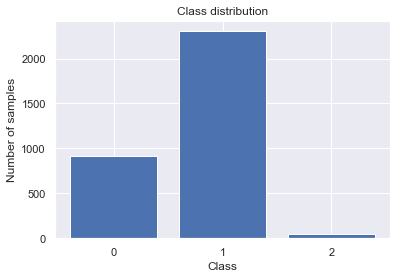

In [20]:
# Look at the distribution of the classes in the target feature
plot_class_distribution(y_train)

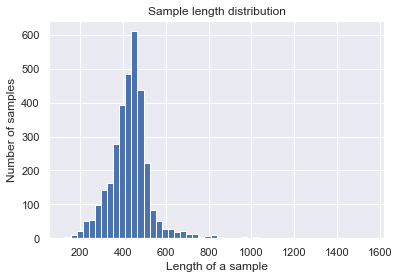

In [21]:
# Plot the length of chars in the samples
plot_sample_length_distribution(X_train)

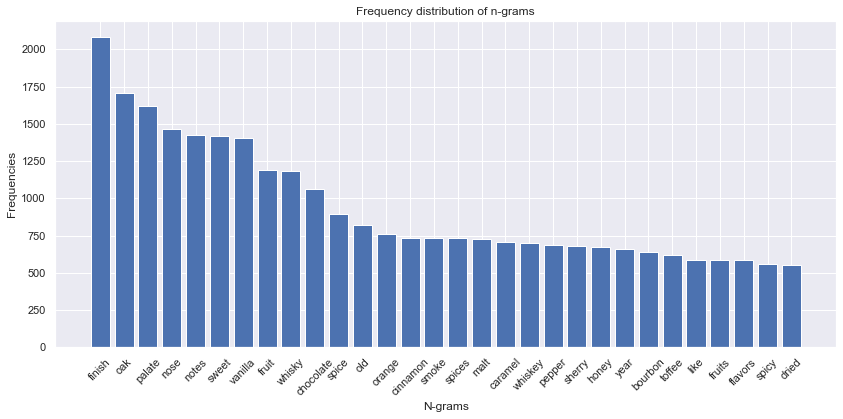

In [22]:
# PLot the counts of the top 30 ngrams
plot_frequency_distribution_of_ngrams(X_train,
                                     ngram_range=(1, 2),
                                     num_ngrams=30)

### Define Pipeline Components

In [23]:
# Instaniate default vecotorizer
vect = TfidfVectorizer(stop_words='english',
                       ngram_range=(1, 3))

# Instaniate default classifer
clf = LinearSVC()

# Create the pipline
pipe = Pipeline([('vect', vect), ('clf', clf)])

In [24]:
# Get sparse document term matrix
dtm = vect.fit_transform(X_train)

# Convert DTM to dataframe
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())

# Check my work and look at the column names in the DTM
print(dtm.shape)
dtm.columns

(3269, 231179)


Index(['00', '000', '000 700', '000 700 ml', '000 bottle',
       '000 bottle commemorative', '000 bottled', '000 bottled globe',
       '000 bottles', '000 bottles 124',
       ...
       'zuidam', 'zuidam distillers', 'zuidam distillers diverse',
       'zuidam distillers intensified', 'zuidam distillery',
       'zuidam distillery star', 'zuidam dutch', 'zuidam dutch spirits',
       'zuidam uses', 'zuidam uses rye'],
      dtype='object', length=231179)

### Define Your Search Space
You're looking for both the best hyperparameters of your vectorizer and your classification model. 

In [25]:
# Set multiple parameters to check for best
parameters = {
    'vect__max_df': (0.25, 0.30, 0.50, 0.60),
    'vect__min_df': (3, 6, 9, 12, 15),
    'vect__max_features': (6000, 9000, 12000),
    'clf__penalty': ('l1', 'l2'),
    'clf__C': (0.3, 0.5, 1.0, 1.5, 2.0)
}

grid_search = GridSearchCV(pipe, parameters, cv=6, n_jobs=8, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 6 folds for each of 600 candidates, totalling 3600 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   35.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  3.9min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  6.4min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  9.1min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed: 11.7min
[Parallel(n_jobs=8)]: Done 3600 out of 3600 | elapsed: 13.2min finished


GridSearchCV(cv=6, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 3),
                                                        no

In [26]:
# Get the best score from grid search
print(f'Grid Search Best Score: {grid_search.best_score_}\n')

# Look at the best parameters
print(f'Grid Search Best Parameters:\n{grid_search.best_params_}\n')

# Evaluate on my validation set
y_val_pred = grid_search.predict(X_val)
print(f'Grid Search CV Validation Accuracy: {accuracy_score(y_val, y_val_pred)}')

Grid Search Best Score: 0.7512940726749414

Grid Search Best Parameters:
{'clf__C': 0.3, 'clf__penalty': 'l2', 'vect__max_df': 0.5, 'vect__max_features': 12000, 'vect__min_df': 3}

Grid Search CV Validation Accuracy: 0.7555012224938875


In [27]:
# Look at the classification report
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.67      0.31      0.42       228
           1       0.77      0.95      0.85       577
           2       0.00      0.00      0.00        13

    accuracy                           0.76       818
   macro avg       0.48      0.42      0.42       818
weighted avg       0.73      0.76      0.72       818



In [28]:
# Extract the vectorizer and classifier from the grid search pipeline
best_mod = grid_search.best_estimator_
cv_vect = best_mod.named_steps['vect']
cv_clf = best_mod.named_steps['clf']

In [29]:
# Look at the weights of the top 30 features in each class
eli5.show_weights(cv_clf, vec=cv_vect, top=30)

### Make a Submission File
*Note:* In a typical Kaggle competition, you are only allowed two submissions a day, so you only submit if you feel you cannot achieve higher test accuracy. For this competition the max daily submissions are capped at **20**. Submit for each demo and for your assignment. 

In [30]:
# Predictions on test sample
pred = best_mod.predict(test['cleaned'])

In [31]:
submission = pd.DataFrame({'id': test['id'], 'ratingCategory': pred})
submission['ratingCategory'] = submission['ratingCategory'].astype('int64')

In [32]:
# Make Sure the Category is an Integer
submission.head()

,id,ratingCategory
0,3461,1
1,2604,1
2,3341,1
3,3764,1
4,2306,1


In [33]:
subNumber = 0

In [34]:
# Save your Submission File
# Best to Use an Integer or Timestamp for different versions of your model

submission.to_csv(f'./whiskey-reviews-dspt8/submission{subNumber}.csv', index=False)
subNumber += 1

# On this first submission I got 0.76143 on the public leaderboard!!!

## Challenge

You're trying to achieve a minimum of 80% Accuracy on your model.

## Latent Semantic Indexing (Learn)
<a id="p2"></a>

## Follow Along
1. Join the Kaggle Competition
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
4. Make a submission to Kaggle 


### Define Pipeline Components

In [62]:
# Use TruncatedSVD for my LSI model
lsi = TruncatedSVD(algorithm='randomized', n_iter=30)

# Use the best parameters from my grid search for my Tfidf vectorizer
vect = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 3),
    min_df=3,
    max_df=0.5,
    max_features=12000
)

# Instantiate my classifier
clf = RandomForestClassifier(random_state=97)

# Define my pipeline 
#   (make sure to run the vectorizer first or it will throw an error 
#   when fitting about not being able to converting a string to a float)
pipe = Pipeline([
    ('vect', vect),  # TF-IDF Vectorier
    ('lsi', lsi),    # Truncated SVD Dimensionality Reduction
    ('clf', clf)     # RandomForest Classifier
])

# Define my parameters to try
params = {
    'lsi__n_components': stats.randint(100, 3000)
    
}

### Define Your Search Space
You're looking for both the best hyperparameters of your vectorizer and your classification model. 

In [63]:
# Run it through a Randomized Search Cross Validation
random_search = RandomizedSearchCV(pipe, params, cv=3, n_iter=5, 
                                   n_jobs=10, verbose=1)
# Fit the model
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 out of  15 | elapsed:  7.6min remaining:  1.9min
[Parallel(n_jobs=10)]: Done  15 out of  15 | elapsed:  8.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=0.5,
                                                              max_features=12000,
                                                              min_df=3,
                                                       

In [64]:
# Look at the best score
print('Random Search CV Best Score:', random_search.best_score_, '\n')

# Look at the best parameters
print('Random Search CV Best Parameters:', random_search.best_params_, '\n')

# Evaluate on the test data
y_val_rscv_pred = random_search.predict(X_val)
print('Random Search CV Test Accuracy', accuracy_score(y_val, y_val_rscv_pred))

Random Search CV Best Score: 0.7063329991603554 

Random Search CV Best Parameters: {'lsi__n_components': 419} 

Random Search CV Test Accuracy 0.7078239608801956


In [66]:
# Define parameters to try using grid search cv
parameters = {
    'lsi__n_components': [10, 100, 250, 419, 500],
    'vect__max_df': (0.3, 0.5, 0.6, 0.75),
    'clf__max_depth':(5, 10, 15, 20)
}

grid_search = GridSearchCV(pipe, parameters, cv=5, n_jobs=10, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   21.9s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed: 10.1min
[Parallel(n_jobs=10)]: Done 400 out of 400 | elapsed: 24.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=0.5,
                                                        max_features=12000,
                                                        min_df=3,
                                                        ngram_range=(1, 3),
                                                        n

In [67]:
# Look at the best score
print('Grid Search Best Score:', grid_search.best_score_, '\n')

# Look at the best parameters
print('Grid Search Best Parameters:', grid_search.best_params_, '\n')

# Evaluate on the test data
y_val_gs_pred = grid_search.predict(X_val)
print('Grid Search Test Accuracy', accuracy_score(y_val, y_val_gs_pred))

Grid Search Best Score: 0.7295797799851076 

Grid Search Best Parameters: {'clf__max_depth': 10, 'lsi__n_components': 10, 'vect__max_df': 0.3} 

Grid Search Test Accuracy 0.7200488997555012


### Make a Submission File

In [68]:
# Predictions on test sample
pred = grid_search.predict(test['cleaned'])

In [69]:
submission = pd.DataFrame({'id': test['id'], 'ratingCategory':pred})
submission['ratingCategory'] = submission['ratingCategory'].astype('int64')

In [70]:
# Make Sure the Category is an Integer
submission.head()

,id,ratingCategory
0,3461,1
1,2604,1
2,3341,1
3,3764,1
4,2306,1


In [72]:
# Save your Submission File
# Best to Use an Integer or Timestamp for different versions of your model

submission.to_csv(f'./whiskey-reviews-dspt8/submission{subNumber}.csv', index=False)
subNumber += 1

## Challenge

Continue to apply Latent Semantic Indexing (LSI) to various datasets. 

# Word Embeddings with Spacy (Learn)
<a id="p3"></a>

## Follow Along

In [1]:
# Apply to your Dataset

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

from scipy.stats import randint

param_dist = {
    
    'max_depth' : randint(3,10),
    'min_samples_leaf': randint(2,15)
}

In [ ]:
# Continue Word Embedding Work Here


### Make a Submission File

In [ ]:
# Predictions on test sample
pred = ...predict(test['description'])

In [ ]:
submission = pd.DataFrame({'id': test['id'], 'ratingCategory':pred})
submission['ratingCategory'] = submission['ratingCategory'].astype('int64')

In [ ]:
# Make Sure the Category is an Integer
submission.head()

In [ ]:
# Save your Submission File
# Best to Use an Integer or Timestamp for different versions of your model

submission.to_csv(f'./data/submission{subNumber}.csv', index=False)
subNumber += 1

## Challenge

What you should be doing now:
1. Join the Kaggle Competition
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
    - Try to extract word embeddings with Spacy and use those embeddings as your features for a classification model.
4. Make a submission to Kaggle 

# Post Lecture Assignment
<a id="p4"></a>

Your primary assignment this afternoon is to achieve a minimum of 80% accuracy on the Kaggle competition. Once you have achieved 70% accuracy, please work on the following: 

1. Research "Sentiment Analysis". Provide answers in markdown to the following questions: 
    - What is "Sentiment Analysis"? 
    - Is Document Classification different than "Sentiment Analysis"? Provide evidence for your response
    - How do create labeled sentiment data? Are those labels really sentiment?
    - What are common applications of sentiment analysis?
2. Research our why word embeddings worked better for the lecture notebook than on the whiskey competition.
    - This [text classification documentation](https://developers.google.com/machine-learning/guides/text-classification/step-2-5) from Google might be of interest
    - Neural Networks are becoming more popular for document classification. Why is that the case?